Generación del nuevo dataset de datos

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def limpiar_nombre_tramo(nombre):
    correcciones = {
        'ACACUÑA': 'ACUÑA',
        'ACUÑAA': 'ACUÑA',
        'JUÁREZ - LINCOLN': 'JUAREZ LINCOLN',
        'JUÁREZ – LINCOLN': 'JUAREZ LINCOLN'
    }
    return correcciones.get(nombre.strip(), nombre.strip())

# Cargar el dataset original
df = pd.read_csv("Ingresos-RedPropia_CAPUFE.csv")
df.columns = df.columns.str.strip()
df['TRAMO CARRETERO'] = df['TRAMO CARRETERO'].apply(limpiar_nombre_tramo)

meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 
         'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']

datos_transformados = []
for index, row in df.iterrows():
    año = row.get('AÑO')  
    for i, mes in enumerate(meses, 1):
        # Solo colocar 0 si es 2024 y después de septiembre
        if año == 2024 and i > 9:
            ingreso = 0
        else:
            ingreso = row[mes] if pd.notna(row[mes]) else row[mes]  # Mantener NaN si es NaN
            
        if pd.notna(ingreso):  # Solo agregar el registro si hay un valor (no NaN)
            datos_transformados.append({
                'TRAMO': row['TRAMO CARRETERO'],
                'TIPO': row['TIPO'],
                'FECHA': f"{año}-{str(i).zfill(2)}-01",
                'INGRESO': ingreso
            })

# Crear DataFrame y procesar
df_temporal = pd.DataFrame(datos_transformados)
df_temporal['FECHA'] = pd.to_datetime(df_temporal['FECHA'])

# Codificar TIPO y TRAMO
le_tipo = LabelEncoder()
le_tramo = LabelEncoder()
df_temporal['TIPO_COD'] = le_tipo.fit_transform(df_temporal['TIPO'])
df_temporal['TRAMO_COD'] = le_tramo.fit_transform(df_temporal['TRAMO'])

# Ordenar y agregar ID
df_temporal = df_temporal.sort_values(['TRAMO', 'FECHA'])
df_temporal['ID'] = range(1, len(df_temporal) + 1)
df_temporal = df_temporal[['ID', 'TRAMO', 'TIPO', 'FECHA', 'INGRESO', 'TIPO_COD', 'TRAMO_COD']]

# Exportar
df_temporal.to_csv('dataset_transformado_corregido.csv', index=False)


Codigo del analisis de series de Tiempo con tres modelos diferentes.

09:20:34 - cmdstanpy - INFO - Chain [1] start processing
09:20:34 - cmdstanpy - INFO - Chain [1] done processing



Analizando tramo DOVALI JAIME BIS

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00

Resultados para Prophet:
MSE: 2,958,188,826.93
RMSE: 54,389.23

Resultados para Holt-Winters:
MSE: 1,460,497,387.15
RMSE: 38,216.45

Resultados para ARIMA:
MSE: 3,033,556,494.86
RMSE: 55,077.73


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


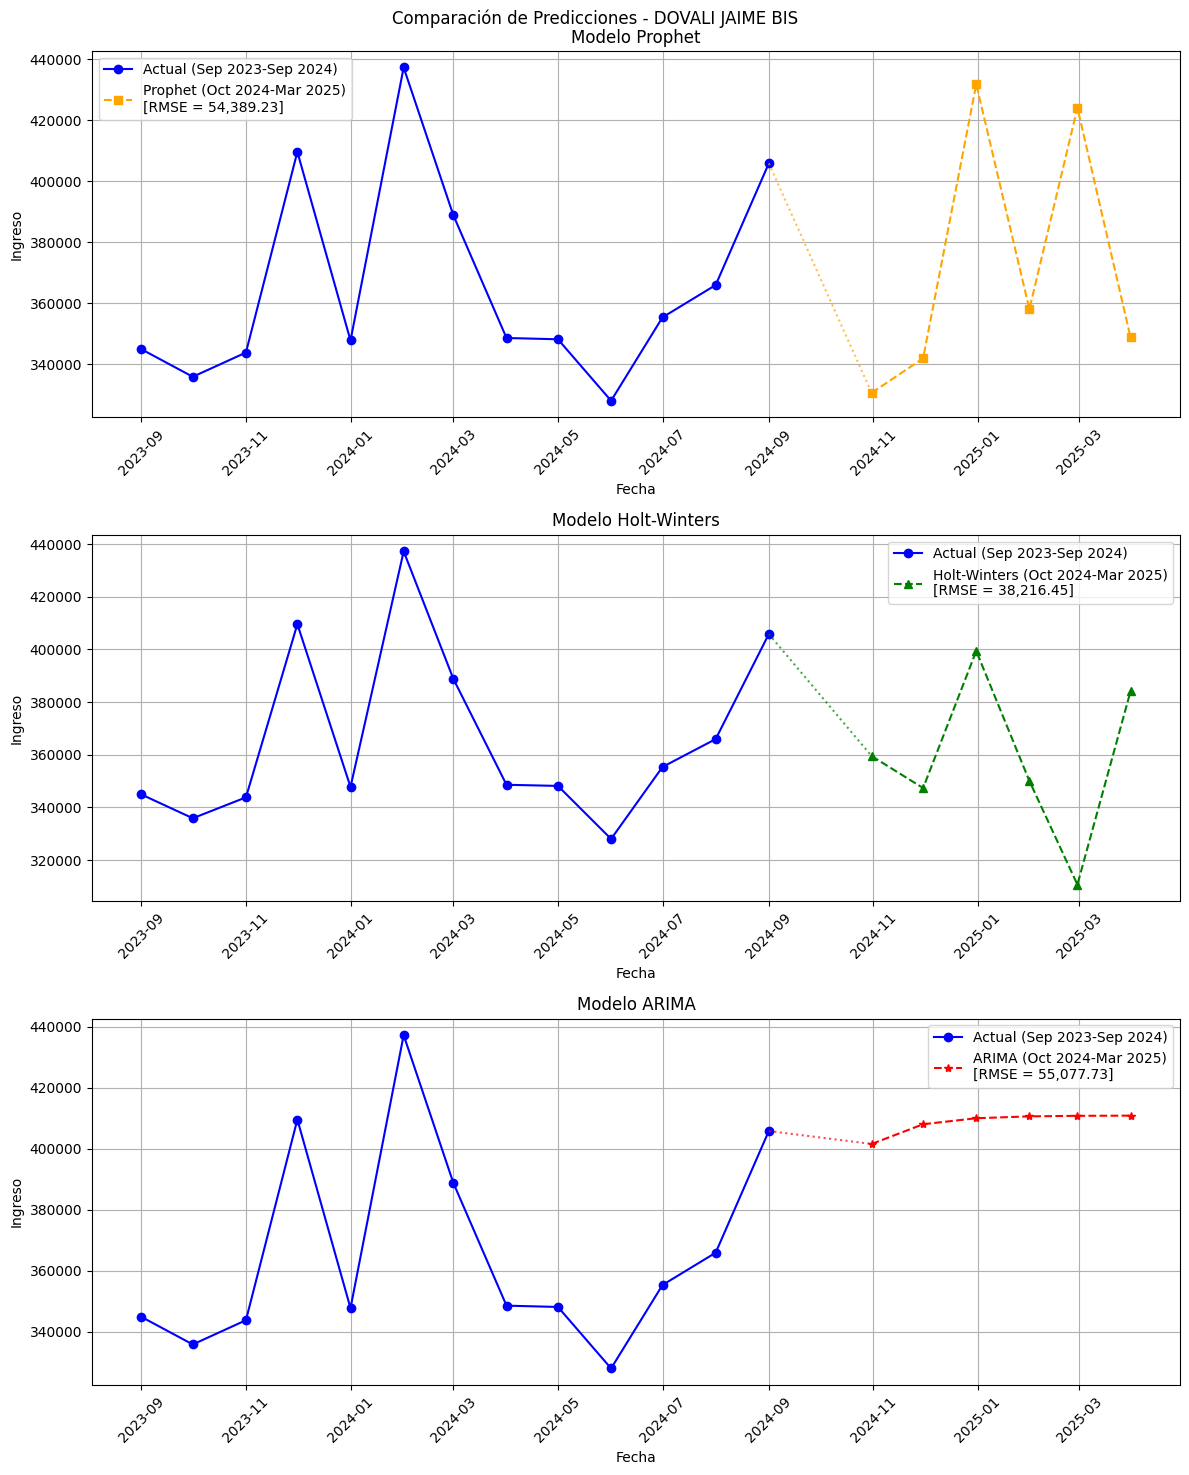

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def prepare_data_prophet(df):
    df_prophet = df[['FECHA', 'INGRESO']].copy()
    df_prophet.columns = ['ds', 'y']
    return df_prophet

def evaluate_model(y_true, y_pred, model_name):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_true_filtered) == 0:
        return {
            'Model': model_name,
            'MSE': np.nan,
            'RMSE': np.nan
        }
    
    mse = mean_squared_error(y_true_filtered, y_pred_filtered)
    rmse = np.sqrt(mse)
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse
    }

def forecast_models(df, tramo_cod, periods=6):
    df_tramo = df[df['TRAMO_COD'] == tramo_cod].copy()
    df_tramo['FECHA'] = pd.to_datetime(df_tramo['FECHA'])
    df_tramo['INGRESO'] = df_tramo['INGRESO'].astype(int)
    
    df_tramo = df_tramo[df_tramo['FECHA'] <= '2024-09-01']
    df_tramo = df_tramo.sort_values(['FECHA', 'INGRESO']).groupby('FECHA').first().reset_index()
    
    train = df_tramo.copy()
    test = df_tramo[df_tramo['FECHA'] >= '2023-09-01'].copy()
    
    print(f"\nTotal de registros disponibles: {len(df_tramo)}")
    print(f"Registros en train: {len(train)}")
    print(f"Registros para visualización: {len(test)}")
    print(f"Rango de fechas mostradas: {test['FECHA'].min()} a {test['FECHA'].max()}")
    
    if len(train) < 24:
        print(f"No hay suficientes datos históricos para el tramo {tramo_cod}")
        return None, None
    
    results = {}
    predictions = {}
    
    try:
        # Prophet
        df_prophet = prepare_data_prophet(train)
        model_prophet = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.05,
        )
        model_prophet.fit(df_prophet)
        future_dates = model_prophet.make_future_dataframe(periods=periods, freq='ME')
        forecast_prophet = model_prophet.predict(future_dates)
        
        # Holt-Winters
        model_hw = ExponentialSmoothing(
            train['INGRESO'],
            seasonal_periods=12,
            trend='add',
            seasonal='add'
        ).fit()
        forecast_hw = model_hw.forecast(periods)
        
        # ARIMA
        model_arima = ARIMA(
            train['INGRESO'],
            order=(1,1,2)
        ).fit()
        forecast_arima = model_arima.forecast(periods)
        
        # Preparar predicciones
        prophet_pred = np.array(forecast_prophet['yhat'][-periods:].values[:periods]).flatten()
        hw_pred = np.array(forecast_hw.values[:periods]).flatten()
        arima_pred = np.array(forecast_arima.values[:periods]).flatten()
        test_y = np.array(test['INGRESO'].values).flatten()
        
        if all(len(x) == periods for x in [prophet_pred, hw_pred, arima_pred]):
            results['Prophet'] = evaluate_model(test_y[-periods:], prophet_pred, 'Prophet')
            results['Holt-Winters'] = evaluate_model(test_y[-periods:], hw_pred, 'Holt-Winters')
            results['ARIMA'] = evaluate_model(test_y[-periods:], arima_pred, 'ARIMA')
            
            predictions['Prophet'] = prophet_pred
            predictions['Holt-Winters'] = hw_pred
            predictions['ARIMA'] = arima_pred
            predictions['Actual'] = test_y
            predictions['Dates'] = test['FECHA'].values
            
            # Solo agregamos los intervalos de confianza de Prophet
            predictions['Prophet_lower'] = forecast_prophet['yhat_lower'][-periods:].values
            predictions['Prophet_upper'] = forecast_prophet['yhat_upper'][-periods:].values
            
            return results, predictions
        else:
            raise ValueError("No todas las predicciones tienen 6 valores")
            
    except Exception as e:
        print(f"Error en el procesamiento del tramo {tramo_cod}: {str(e)}")
        return None, None

def plot_forecasts(predictions, df_tramo, tramo_cod, results):
    if predictions is None:
        return None
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    nombre_tramo = df_tramo[df_tramo['TRAMO_COD'] == tramo_cod]['TRAMO'].iloc[0]
    fig.suptitle(f'Comparación de Predicciones - {nombre_tramo}')
    
    actual_dates = predictions['Dates']
    last_date = actual_dates[-1]
    future_dates = pd.date_range(start=last_date, periods=7, freq='ME')[1:]
    
    models = [
        ('Prophet', 's', 'orange'),
        ('Holt-Winters', '^', 'green'),
        ('ARIMA', '*', 'red')
    ]
    
    for i, (model_name, marker, color) in enumerate(models):
        rmse = results[model_name]['RMSE']
        
        # Datos actuales
        axes[i].plot(actual_dates, predictions['Actual'], 
                    label='Actual (Sep 2023-Sep 2024)', marker='o', color='blue')
        
        # Predicciones con dos líneas en la leyenda
        axes[i].plot(future_dates, predictions[model_name], 
                    label=f'{model_name} (Oct 2024-Mar 2025)\n[RMSE = {rmse:,.2f}]', 
                    marker=marker, linestyle='--', color=color)
        
        # Línea de conexión
        connection_dates = [last_date, future_dates[0]]
        connection_values = [predictions['Actual'][-1], predictions[model_name][0]]
        axes[i].plot(connection_dates, connection_values, 
                    linestyle=':', color=color, alpha=0.7)
        
        axes[i].set_xlabel('Fecha')
        axes[i].set_ylabel('Ingreso')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f'Modelo {model_name}')
    
    plt.tight_layout()
    return plt

def analizar_tramo(df, tramo_cod):
    print(f"\nAnalizando tramo {df[df['TRAMO_COD'] == tramo_cod]['TRAMO'].iloc[0]}")
    results, predictions = forecast_models(df, tramo_cod)
    
    if results is not None:
        for model, metrics in results.items():
            print(f"\nResultados para {model}:")
            print(f"MSE: {metrics['MSE']:,.2f}")
            print(f"RMSE: {metrics['RMSE']:,.2f}")
        
        plot = plot_forecasts(predictions, df, tramo_cod, results)
        if plot:
            plt.show()
    else:
        print("No se pudieron generar resultados para este tramo.")

# Uso
df = pd.read_csv('dataset_transformado_corregido.csv')
analizar_tramo(df, 9)

El siguiente codigo nos sirvio para poder generar todas las graficas de todos los tramos automaticamente, para no ejecutar el codigo por cada tramo individualmente.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

resultados_rmse = []

# Cargar el dataset
df = pd.read_csv('dataset_transformado_corregido.csv')

# Iterar sobre todos los tramos
for tramo_cod in range(33):  # 0 a 32
    print(f"\nProcesando tramo {tramo_cod}")
    results, predictions = forecast_models(df, tramo_cod)
    
    if results is not None:
        # Guardar resultados RMSE
        nombre_tramo = df[df['TRAMO_COD'] == tramo_cod]['TRAMO'].iloc[0]
        resultados_rmse.append({
            'TRAMO_COD': tramo_cod,
            'TRAMO': nombre_tramo,
            'RMSE_Prophet': results['Prophet']['RMSE'],
            'RMSE_HoltWinters': results['Holt-Winters']['RMSE'],
            'RMSE_ARIMA': results['ARIMA']['RMSE']
        })
        
        # Crear y guardar gráfica
        plot = plot_forecasts(predictions, df, tramo_cod, results)
        if plot:
            plt.savefig(f'Grafica{tramo_cod}.png')
            plt.close()  # Cerrar la figura para liberar memoria
    
    print(f"Tramo {tramo_cod} completado")

# Crear DataFrame con los resultados y guardarlo como CSV
df_resultados = pd.DataFrame(resultados_rmse)
df_resultados.to_csv('resultados_rmse.csv', index=False)

print("\nProceso completado:")
print(f"- Se analizaron {len(resultados_rmse)} tramos")
print("- Las gráficas se guardaron como Grafica0.png, Grafica1.png, etc.")
print("- Los resultados RMSE se guardaron en resultados_rmse.csv")

09:23:47 - cmdstanpy - INFO - Chain [1] start processing



Procesando tramo 0

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


09:23:48 - cmdstanpy - INFO - Chain [1] done processing
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:23:48 - cmdstanpy - INFO - Chain [1] start processing
09:23:48 - cmdstanpy - INFO - Chain [1] done processing


Tramo 0 completado

Procesando tramo 1

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:49 - cmdstanpy - INFO - Chain [1] start processing
09:23:49 - cmdstanpy - INFO - Chain [1] done processing


Tramo 1 completado

Procesando tramo 2

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:23:49 - cmdstanpy - INFO - Chain [1] start processing


Tramo 2 completado

Procesando tramo 3

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


09:23:50 - cmdstanpy - INFO - Chain [1] done processing
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:50 - cmdstanpy - INFO - Chain [1] start processing
09:23:50 - cmdstanpy - INFO - Chain [1] done processing


Tramo 3 completado

Procesando tramo 4

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:51 - cmdstanpy - INFO - Chain [1] start processing
09:23:51 - cmdstanpy - INFO - Chain [1] done processing


Tramo 4 completado

Procesando tramo 5

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:51 - cmdstanpy - INFO - Chain [1] start processing
09:23:51 - cmdstanpy - INFO - Chain [1] done processing


Tramo 5 completado

Procesando tramo 6

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:52 - cmdstanpy - INFO - Chain [1] start processing
09:23:52 - cmdstanpy - INFO - Chain [1] done processing


Tramo 6 completado

Procesando tramo 7

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:52 - cmdstanpy - INFO - Chain [1] start processing
09:23:52 - cmdstanpy - INFO - Chain [1] done processing


Tramo 7 completado

Procesando tramo 8

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:23:53 - cmdstanpy - INFO - Chain [1] start processing
09:23:53 - cmdstanpy - INFO - Chain [1] done processing


Tramo 8 completado

Procesando tramo 9

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:23:53 - cmdstanpy - INFO - Chain [1] start processing
09:23:53 - cmdstanpy - INFO - Chain [1] done processing


Tramo 9 completado

Procesando tramo 10

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:54 - cmdstanpy - INFO - Chain [1] start processing
09:23:54 - cmdstanpy - INFO - Chain [1] done processing


Tramo 10 completado

Procesando tramo 11

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:54 - cmdstanpy - INFO - Chain [1] start processing
09:23:54 - cmdstanpy - INFO - Chain [1] done processing


Tramo 11 completado

Procesando tramo 12

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
09:23:55 - cmdstanpy - INFO - Chain [1] start processing
09:23:55 - cmdstanpy - INFO - Chain [1] done processing


Tramo 12 completado

Procesando tramo 13

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:55 - cmdstanpy - INFO - Chain [1] start processing
09:23:55 - cmdstanpy - INFO - Chain [1] done processing


Tramo 13 completado

Procesando tramo 14

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:56 - cmdstanpy - INFO - Chain [1] start processing
09:23:56 - cmdstanpy - INFO - Chain [1] done processing


Tramo 14 completado

Procesando tramo 15

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:56 - cmdstanpy - INFO - Chain [1] start processing


Tramo 15 completado

Procesando tramo 16

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


09:23:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:57 - cmdstanpy - INFO - Chain [1] start processing
09:23:57 - cmdstanpy - INFO - Chain [1] done processing


Tramo 16 completado

Procesando tramo 17

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:58 - cmdstanpy - INFO - Chain [1] start processing
09:23:58 - cmdstanpy - INFO - Chain [1] done processing


Tramo 17 completado

Procesando tramo 18

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:58 - cmdstanpy - INFO - Chain [1] start processing


Tramo 18 completado

Procesando tramo 19

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


09:23:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:59 - cmdstanpy - INFO - Chain [1] start processing
09:23:59 - cmdstanpy - INFO - Chain [1] done processing


Tramo 19 completado

Procesando tramo 20

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:23:59 - cmdstanpy - INFO - Chain [1] start processing
09:23:59 - cmdstanpy - INFO - Chain [1] done processing


Tramo 20 completado

Procesando tramo 21

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:00 - cmdstanpy - INFO - Chain [1] start processing
09:24:00 - cmdstanpy - INFO - Chain [1] done processing


Tramo 21 completado

Procesando tramo 22

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:00 - cmdstanpy - INFO - Chain [1] start processing


Tramo 22 completado

Procesando tramo 23

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


09:24:01 - cmdstanpy - INFO - Chain [1] done processing
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:01 - cmdstanpy - INFO - Chain [1] start processing
09:24:01 - cmdstanpy - INFO - Chain [1] done processing


Tramo 23 completado

Procesando tramo 24

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:02 - cmdstanpy - INFO - Chain [1] start processing
09:24:02 - cmdstanpy - INFO - Chain [1] done processing


Tramo 24 completado

Procesando tramo 25

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:02 - cmdstanpy - INFO - Chain [1] start processing
09:24:02 - cmdstanpy - INFO - Chain [1] done processing


Tramo 25 completado

Procesando tramo 26

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:03 - cmdstanpy - INFO - Chain [1] start processing
09:24:03 - cmdstanpy - INFO - Chain [1] done processing


Tramo 26 completado

Procesando tramo 27

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:03 - cmdstanpy - INFO - Chain [1] start processing
09:24:03 - cmdstanpy - INFO - Chain [1] done processing


Tramo 27 completado

Procesando tramo 28

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:04 - cmdstanpy - INFO - Chain [1] start processing
09:24:04 - cmdstanpy - INFO - Chain [1] done processing


Tramo 28 completado

Procesando tramo 29

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:04 - cmdstanpy - INFO - Chain [1] start processing
09:24:04 - cmdstanpy - INFO - Chain [1] done processing


Tramo 29 completado

Procesando tramo 30

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:05 - cmdstanpy - INFO - Chain [1] start processing
09:24:05 - cmdstanpy - INFO - Chain [1] done processing


Tramo 30 completado

Procesando tramo 31

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
09:24:05 - cmdstanpy - INFO - Chain [1] start processing
09:24:05 - cmdstanpy - INFO - Chain [1] done processing


Tramo 31 completado

Procesando tramo 32

Total de registros disponibles: 45
Registros en train: 45
Registros para visualización: 13
Rango de fechas mostradas: 2023-09-01 00:00:00 a 2024-09-01 00:00:00


/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yahir/Universidad/cuatri9/analisis_datos/c3/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tramo 32 completado

Proceso completado:
- Se analizaron 33 tramos
- Las gráficas se guardaron como Grafica0.png, Grafica1.png, etc.
- Los resultados RMSE se guardaron en resultados_rmse.csv
